In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from dataset_parser import (
    get_ordered_syllable_for_song,
    get_recording_time_from_filename,
    load_single_bird_syllable_csv,
    split_dataset_by_surgery_date
)

In [21]:
import pprint
file_path = 'Modeling_phys_canary/USA5288_decoded.csv'

results = load_single_bird_syllable_csv(file_path)
print(len(results))
pprint.pprint(results[1])

52151
{'animal_id': 'USA5288',
 'file_name': 'USA5288_45355.32438532_3_4_9_0_38.wav',
 'ordered_and_timed_syllables': [('8', 0.0, 1813.3333333333335),
                                 ('21', 1813.3333333333335, 3348.730158730159),
                                 ('22', 3348.730158730159, 4425.396825396826),
                                 ('21', 4425.396825396826, 4611.587301587302),
                                 ('22', 4611.587301587302, 4619.68253968254),
                                 ('21', 4619.68253968254, 4622.380952380952),
                                 ('22', 4622.380952380952, 4625.079365079366),
                                 ('21', 4625.079365079366, 4630.476190476191),
                                 ('26', 4630.476190476191, 4751.904761904762),
                                 ('23', 4751.904761904762, 5010.952380952382),
                                 ('2', 5010.952380952382, 5785.396825396826),
                                 ('3', 5785.396825396826, 804

In [22]:
pprint.pprint(' '.join([
    s[0]
    for s in results[1]['ordered_and_timed_syllables']
]))

'8 21 22 21 22 21 22 21 26 23 2 3 26 5 11 14'


In [23]:
import json
from datetime import datetime
json_file_path = 'Modeling_phys_canary/USA5288_creation_data.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)

    surgery_treatment_date = datetime.strptime(
        data['treatment_date'], '%Y-%m-%d')

surgery_treatment_date

datetime.datetime(2024, 4, 9, 0, 0)

In [24]:
results_pre_surgery, results_post_surgery = split_dataset_by_surgery_date(results, surgery_treatment_date)
len(results_pre_surgery), len(results_post_surgery)

(33374, 18777)

# Generate a PST for each syllable ignore duration

In [25]:
presurgery_dataset = []
for result in results_pre_surgery:
    ordered_syllables = [
        str(syl_data[0])
        for syl_data in result['ordered_and_timed_syllables']
    ]

    if len(ordered_syllables) == 0:
        continue

    presurgery_dataset.append(ordered_syllables)


print(len(presurgery_dataset))
presurgery_dataset[0:1]

7507


[['8',
  '21',
  '22',
  '21',
  '22',
  '21',
  '22',
  '21',
  '26',
  '23',
  '2',
  '3',
  '26',
  '5',
  '11',
  '14']]

In [39]:
import numpy as np
from pypst.transition_mat import build_transition_matrix, build_alphabet_from_dataset
from pypst.pst_learn import pst_learn

alphabet = build_alphabet_from_dataset(presurgery_dataset)
len(alphabet)

30

In [47]:
transition_matrix = build_transition_matrix(presurgery_dataset, 4, alphabet)

In [48]:
transition_matrix['N']

array([77292, 69785, 62533, 56020, 50015], dtype=uint32)

In [52]:
transition_matrix = build_transition_matrix(presurgery_dataset, 4, alphabet)

L = 4;
p_min = .001 #0.0073 #0.1e-15 #0.0073;
g_min = 0.00185;
r = 1.2;
alpha = 0;

pst_learn_result = pst_learn(
    transition_matrix['occurrence_mats'],
    transition_matrix['alphabet'],
    transition_matrix['N'],
    L, p_min, g_min, r, alpha)

In [55]:
from graphviz import Digraph

def visualize_pst(tbar):
    dot = Digraph(comment='Probabilistic Suffix Tree')

    # Iterate over the depths of the tree
    for depth, nodes in enumerate(tbar):
        if 'string' in nodes:
            for i, label in enumerate(nodes['label']):
                # Create a unique node identifier (based on depth and index)
                node_id = f'{depth}_{i}'

                # Label the node with the string and probability (if available)
                node_label = f"Label: {label}"#\nFreq: {nodes['f'][i]}"
                dot.node(node_id, node_label)

                # If the node has a parent, create an edge
                if depth > 0 and nodes['parent']:
                    parent_id, parent_depth = nodes['parent'][i]
                    parent_node_id = f'{parent_depth}_{parent_id}'
                    dot.edge(parent_node_id, node_id)

    # Render the graph (this will save it as a .gv file and also display)
    dot.render('pst_tree', view=False)
    return dot
# Visualize the PST
dot = visualize_pst(pst_learn_result)

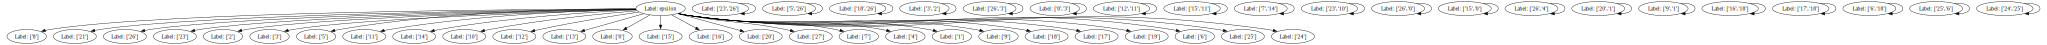

In [56]:
dot

In [ ]:
import numpy as np

f_mat = trans_mat_result['occurrence_mats']
alphabet = trans_mat_result['alphabet']
#print(alphabet)
N = trans_mat_result['N']
p_min=.0073

sbar = [
        a for a in alphabet
        if np.single(f_mat[0][alphabet[a]] / N[0]) >= p_min
    ]
sbar

In [128]:
alphabet

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15,
 '16': 16,
 '17': 17,
 '18': 18,
 '19': 19,
 '20': 20,
 '21': 21,
 '22': 22,
 '23': 23,
 '24': 24,
 '25': 25,
 '26': 26,
 '27': 27,
 '28': 28,
 '29': 29}

In [134]:
alphabet['1']

1

In [135]:
a = '1'
np.single(f_mat[0][alphabet[a]] / N[0])

np.float32(0.04524401)

In [ ]:
### OLD

In [84]:
import numpy as np

def build_alphabet_from_dataset(dataset):
    """Iterate through the dataset and build an alphabet of unique items."""
    alphabet = set()
    for row in dataset:
        for item in row:
            alphabet.add(item)

    # todo - remove this int conversion if we go to a string based alphabet
    tmp = sorted(list(alphabet), key=lambda x: int(x))
    alphabet_map = {
        item: idx
        for idx, item in enumerate(tmp)
    }
    return alphabet_map

alphabet = build_alphabet_from_dataset(presurgery_dataset)
#print(alphabet)

order = 3
alphabet_length = len(alphabet)

#f_mat = [
#    np.zeros((alphabet_length,) * (i+1), dtype=np.uint16)
#    for i in range(min(order + 1, 10))
#]


occurrence_mats = [
    np.zeros((alphabet_length,) * (i+1), dtype=np.uint16)
    for i in range(order)
]

pi = np.zeros(alphabet_length, dtype=np.uint16)
n = np.zeros(order + 1, dtype=np.uint32)

len(occurrence_mats), n.shape


#alphabet_length, f_mat[0].shape
#pi = np.zeros(ncat, dtype=np.uint16)
#n = np.zeros(min(order + 1, 10), dtype=np.uint32)

(3, (4,))

In [85]:
x = [1,2]

occurrence_mats[1][1,2] = 5
occurrence_mats[1][*x] += 1
occurrence_mats[1][*x]

np.uint16(6)

In [91]:
def build_alphabet_from_dataset(dataset):
    """Iterate through the dataset and build an alphabet of unique items."""
    alphabet = set()
    for row in dataset:
        for item in row:
            alphabet.add(item)

    # todo - remove this int conversion if we go to a string based alphabet
    tmp = sorted(list(alphabet), key=lambda x: int(x))
    alphabet_map = {
        item: idx
        for idx, item in enumerate(tmp)
    }
    return alphabet_map


def build_transition_matrix(dataset, order, alphabet = None):
    """

    N [alphabet size, 1] - vector of total entries for each order
    p_starting_symbol (Pi) [alphabet size, 1] - probability distribution over the possible starting states (or symbols) in a sequence. It represents the likelihood of each symbol being the first one observed in a sequence.
    """

    if alphabet is None:
        alphabet = build_alphabet_from_dataset(dataset)

    alphabet_length = len(alphabet)

    occurrence_mats = [
        np.zeros((alphabet_length,) * (i+1), dtype=np.uint16)
        for i in range(order)
    ]

    p_starting_symbol = np.zeros(alphabet_length, dtype=np.uint16)
    n = np.zeros(order + 1, dtype=np.uint32)

    for cur_sequence in dataset:
        print(cur_sequence)
        for cur_item_index in range(len(cur_sequence)):

            cur_item = cur_sequence[cur_item_index]
            cur_item_alphabet_index = alphabet[cur_item]

            # Increment the occurrence count of the current syllable
            p_starting_symbol[cur_item_alphabet_index] += 1

            # Iterate through each order of the PST and increment the co-occurrence count
            # of the current syllable with the next order syllables
            # co_occuring_indexes ends up being a list of indexes of the next order syllables
            # that can be used to dereference the currect element of the co-occurrence matrix
            co_occuring_indexes = []
            for cur_order in range(0, order):
                # If the sequence is shorter than the current order, skip
                if len(cur_sequence) <= cur_item_index + cur_order:
                    continue

                next_order_item = cur_sequence[cur_item_index + cur_order]
                next_order_syllables_alphabet_index = alphabet[next_order_item]

                co_occuring_indexes.append(next_order_syllables_alphabet_index)

                print(co_occuring_indexes)

                occurrence_mats[cur_order][*co_occuring_indexes] += 1


build_transition_matrix(presurgery_dataset, 3, alphabet)

['8', '21', '22', '21', '22', '21', '22', '21', '26', '23', '2', '3', '26', '5', '11', '14']
[8]
[8, 21]
[8, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 26]
[21]
[21, 26]
[21, 26, 23]
[26]
[26, 23]
[26, 23, 2]
[23]
[23, 2]
[23, 2, 3]
[2]
[2, 3]
[2, 3, 26]
[3]
[3, 26]
[3, 26, 5]
[26]
[26, 5]
[26, 5, 11]
[5]
[5, 11]
[5, 11, 14]
[11]
[11, 14]
[14]
['10', '26', '10', '26', '10', '23', '2', '3', '10', '3', '26', '5', '26', '5', '11', '12', '13', '0', '15', '16', '11', '12', '13', '0']
[10]
[10, 26]
[10, 26, 10]
[26]
[26, 10]
[26, 10, 26]
[10]
[10, 26]
[10, 26, 10]
[26]
[26, 10]
[26, 10, 23]
[10]
[10, 23]
[10, 23, 2]
[23]
[23, 2]
[23, 2, 3]
[2]
[2, 3]
[2, 3, 10]
[3]
[3, 10]
[3, 10, 3]
[10]
[10, 3]
[10, 3, 26]
[3]
[3, 26]
[3, 26, 5]
[26]
[26, 5]
[26, 5, 26]
[5]
[5, 26]
[5, 26, 5]
[26]
[26, 5]
[26, 5, 11]
[5]
[5, 11]
[5, 11, 12]
[11]
[11, 12]
[11, 12, 13]
[12]
[12, 13]
[12,

In [90]:
# Iterate over the songs
for cur_song_syllables in dataset:
    print(cur_song_syllables)
    for cur_syllable_index in range(len(cur_song_syllables)):

        cur_syllable = cur_song_syllables[cur_syllable_index]
        cur_syllable_alphabet_index = alphabet[cur_syllable]

        # Increment the occurrence count of the current syllable
        p_starting_symbol[cur_syllable_alphabet_index] += 1

        co_occuring_indexes = []
        for cur_order in range(0, order):
            if len(cur_song_syllables) <= cur_syllable_index + cur_order:
                continue

            next_order_syllables = cur_song_syllables[cur_syllable_index + cur_order]
            next_order_syllables_alphabet_index = alphabet[next_order_syllables]

            co_occuring_indexes.append(next_order_syllables_alphabet_index)

            print(co_occuring_indexes)

            occurrence_mats[cur_order][*co_occuring_indexes] += 1

    break
    """
            n[cur_order] += 1

            #occurrence_mats[cur_order]

            #next_syllable = cur_song_syllables[cur_syllable_index + i]
            #next_syllable_alphabet_index = alphabet[next_syllable]

            #occurrence_mats[i][cur_syllable_alphabet_index, next_syllable_alphabet_index] += 1



        # order 0
        cur_item = row[item_index]
        cur_item_alphabet_index = alphabet[cur_item]

        f_mat[0, cur_item_alphabet_index] += 1

        for i in range(1, order):
            next_idx = alphabet[song[i+1])
            f_mat[1][idx, next_idx] += 1
    """
occurrence_mats[0]

['8', '21', '22', '21', '22', '21', '22', '21', '26', '23', '2', '3', '26', '5', '11', '14']
[8]
[8, 21]
[8, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 22]
[21]
[21, 22]
[21, 22, 21]
[22]
[22, 21]
[22, 21, 26]
[21]
[21, 26]
[21, 26, 23]
[26]
[26, 23]
[26, 23, 2]
[23]
[23, 2]
[23, 2, 3]
[2]
[2, 3]
[2, 3, 26]
[3]
[3, 26]
[3, 26, 5]
[26]
[26, 5]
[26, 5, 11]
[5]
[5, 11]
[5, 11, 14]
[11]
[11, 14]
[14]


array([ 0,  0,  4,  4,  0,  4,  0,  0,  4,  0,  0,  4,  0,  0,  3,  0,  0,
        0,  0,  0,  0, 16, 12,  4,  0,  0,  8,  0,  0,  0], dtype=uint16)

In [209]:
# sci-kit learn read mat file

mat_file = 'Russel_TREE.mat'


from scipy.io import loadmat
data = loadmat(mat_file)



import numpy as np

def mat_struct_to_dict(mat_struct):
    """
    Recursively converts a MATLAB-style struct to a Python dictionary.
    """
    if isinstance(mat_struct, np.ndarray) and mat_struct.dtype.names:
        # Convert structured array into a dictionary
        data_dict = {}
        for field_name in mat_struct.dtype.names:
            data_dict[field_name] = mat_struct_to_dict(mat_struct[field_name])
        return data_dict
    elif isinstance(mat_struct, np.ndarray):
        # If it's just an ndarray, convert to list
        return mat_struct.tolist()
    else:
        # If it's a basic type, return as is
        return mat_struct

# Assuming mat_data is the dictionary loaded from loadmat()
converted_data = mat_struct_to_dict(data['TREE'])


In [214]:
converted_data.keys()

dict_keys(['string', 'parent', 'label', 'internal', 'g_sigma_s', 'p', 'f'])

In [215]:
converted_data['p']

[[array([[1]], dtype=uint8),
  array([[0.02777778, 0.05555556, 0.08333334, 0.11111111, 0.1388889 ,
          0.16666667, 0.1388889 , 0.11111111, 0.08333334, 0.05555556]],
        dtype=float32),
  array([], shape=(1, 0), dtype=float64),
  array([], shape=(1, 0), dtype=float64),
  array([], shape=(1, 0), dtype=float64),
  array([], shape=(1, 0), dtype=float64)]]